In [181]:
seed = 605

from pandas_profiling import ProfileReport
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
import gamma_poisson_factorization

import pickle
import matplotlib.pyplot as plt
import pandas as pd

from mlxtend.plotting import plot_decision_regions

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

from mlxtend.feature_extraction import PrincipalComponentAnalysis

In [6]:
def Combine_SkillClusterFamilies(series):
    unique_fam = list(series.unique())
    if 'na' in unique_fam:
        if unique_fam is not ['na']:
            unique_fam.remove('na')
        return ' '.join(unique_fam)
    return ' '.join(unique_fam)

def shorten_4_to_2(self):
    return str(self)[:2]

wdir = '/nfs/turbo/fspp-epi/projects/SkillDemand/'
df_skills = pd.read_csv(wdir + 'data_final/Global_Skill_Families/2015/Global_Skill_Families_2015-05.csv')
df_certs = pd.read_csv(wdir + 'data_raw/Certs/2015/Certs_2015-05.txt', delimiter='\t', encoding='latin1')
df_main = pd.read_csv(wdir + 'data_raw/Main/2015/Main_2015-05.txt', delimiter='\t', encoding='latin1')
df_majors = pd.read_csv(wdir + 'data_final/Skill_Groups/2015/Skill_Groups_2015-05.csv', usecols=['BGTJobId', 'CIP4'])
raw_skills = pd.read_csv(wdir + 'data_raw/Skill/2015/Skills_2015-05.txt', delimiter='\t', encoding='latin1')

df_majors['CIP2'] = df_majors['CIP4'].apply(shorten_4_to_2)

features = ['BGTJobId', 'BestFitMSAName', 'CleanTitle', 'Employer', 'Exp',
       'SectorName', 'SkillClusterFamily', 'SOCName']
features_no_skill = ['BGTJobId', 'BestFitMSAName', 'CleanTitle', 'Employer', 'Exp',
       'SectorName', 'SOCName']

df = df_main[df_main.Edu==16][features_no_skill]
df_sample = df.sample(frac=0.3, random_state=1) # Sample DF or else we're gonna have an error

labelled_df_sample = df_sample.merge(df_majors[['BGTJobId', 'CIP2', 'CIP4']], on='BGTJobId')
labelled_df_sample = labelled_df_sample.replace(False, 0) # Booleans -> Int
labelled_df_w_skills = labelled_df_sample.merge(raw_skills[['BGTJobId','SkillClusterFamily']], on='BGTJobId')
labelled_data = labelled_df_w_skills.groupby(['BGTJobId', 'BestFitMSAName', 'CleanTitle', 'Employer', 'Exp',
       'SectorName', 'SOCName'])['SkillClusterFamily'].apply(Combine_SkillClusterFamilies).reset_index()

In [10]:
# 70,000 is a lot -- Going to use 5,000 for this workshop

In [174]:
features_df = labelled_data.sample(10000, random_state = seed) # features df has job id, x df doesn't 
df_labels = features_df.merge(df_majors[['BGTJobId', 'CIP2', 'CIP4']], on='BGTJobId')[['BGTJobId', 'CIP2', 'CIP4']]

In [175]:
y_df = pd.DataFrame()
labels_CIP = [['is_business', '52'], ['is_compsci', '11'], 
              ['is_comms', '9.'], ['is_publicadmin', '44'],
['is_business_admin_02', 52.02], ['is_computer_science_07', 11.07], 
['is_comm_01', 9.01], ['is_social_work', 44.07]]
for entry in labels_CIP:
    if isinstance(entry[1], float):
        y_df[entry[0]] = df_labels.groupby(['BGTJobId']).apply(lambda x: (any(x.CIP4 == entry[1])))
    else:
        y_df[entry[0]] = df_labels.groupby(['BGTJobId']).apply(lambda x: (any(x.CIP2 == entry[1])))

In [263]:
full_df = features_df.merge(y_df, on='BGTJobId')

In [269]:
x = full_df.iloc[:,1:8]
y = full_df.iloc[:,8:]

In [271]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

In [272]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
        col_name.append('break')
    return col_name

transformer = ColumnTransformer( [('BestFitMSAName_Cat', gamma_poisson_factorization.OnlineGammaPoissonFactorization( \
                    n_topics=10, r=.3, rho=None,ngram_range=(1, 1), max_iter=2, min_iter=1, \
                    tol=1e-4, random_state=18, init='k-means++',rescale_W=False),'BestFitMSAName'),
                                  ('CleanTitle_Cat', gamma_poisson_factorization.OnlineGammaPoissonFactorization( \
                    n_topics=30, r=.3, rho=None,ngram_range=(1, 1), max_iter=2, min_iter=1, \
                    tol=1e-4, random_state=18, init='k-means++',rescale_W=False),'CleanTitle'),
                                 ('Employer_Cat', gamma_poisson_factorization.OnlineGammaPoissonFactorization( \
                    n_topics=30, r=.3, rho=None,ngram_range=(1, 1), max_iter=2, min_iter=1, \
                    tol=1e-4, random_state=18, init='k-means++',rescale_W=False),'Employer'),
                                   ('SectorName_Cat', gamma_poisson_factorization.OnlineGammaPoissonFactorization( \
                    n_topics=10, r=.3, rho=None,ngram_range=(1, 1), max_iter=2, min_iter=1, \
                    tol=1e-4, random_state=18, init='k-means++',rescale_W=False),'SectorName'),
                                   ('SkillClusterFamily_Cat', gamma_poisson_factorization.OnlineGammaPoissonFactorization( \
                    n_topics=10, r=.3, rho=None,ngram_range=(1, 1), max_iter=2, min_iter=1, \
                    tol=1e-4, random_state=18, init='k-means++',rescale_W=False),'SkillClusterFamily'),
                                   ('SOCName_Cat', gamma_poisson_factorization.OnlineGammaPoissonFactorization( \
                    n_topics=10, r=.3, rho=None,ngram_range=(1, 1), max_iter=2, min_iter=1, \
                    tol=1e-4, random_state=18, init='k-means++',rescale_W=False),'SOCName'),
                                  ],remainder=StandardScaler())

transformer.fit(x_train)

get_column_names_from_ColumnTransformer(transformer)

['tampa, memphis, temple',
 'valley, cleveland, beeville',
 'francisco, corsicana, carson',
 'ks, sikeston, mission',
 'wing, virginia, elgin',
 'ky, jersey, kennewick',
 'redmond, bremerton, bernardino',
 'goshen, beach, sheboygan',
 'dubuque, albuquerque, honolulu',
 'flagstaff, oxford, fort',
 'break',
 'azure, grizzlies, mazzetti',
 'loyalty, royalty, playa',
 'people, ppe, pipeline',
 '00045767, 00040705, 00045885',
 'flight, life, file',
 'snr, resin, sprint',
 'reference, researcher, mergers',
 'xerox, tax, text',
 'mammalian, mammal, managment',
 'programmer, program, major',
 'database, broadband, ambassador',
 'structures, futures, results',
 'traffic, staff, off',
 'initiatives, ascii, asic',
 'guru, drug, gerdau',
 'business, businesses, suburbs',
 'aag, ag, gaap',
 'www, ww, worldwide',
 'settlement, investment, investments',
 'bookkeeper, banker, bkg',
 'accountant, accountat, accountan',
 'devel, developer, valve',
 'heights, hh, dhhs',
 'equity, liquidity, quality',
 'c

In [273]:
x_train_transformed = transformer.transform(x_train)
x_test_transformed = transformer.transform(x_test)

In [274]:
pca = PrincipalComponentAnalysis(n_components=None)
pca.fit(x_train_transformed)
X_pca = pca.transform(x_train_transformed)

In [275]:
tot = sum(pca.e_vals_)
var_exp = [(i / tot)*100 for i in sorted(pca.e_vals_, reverse=True)]
cum_var_exp = np.cumsum(pca.e_vals_normalized_*100)

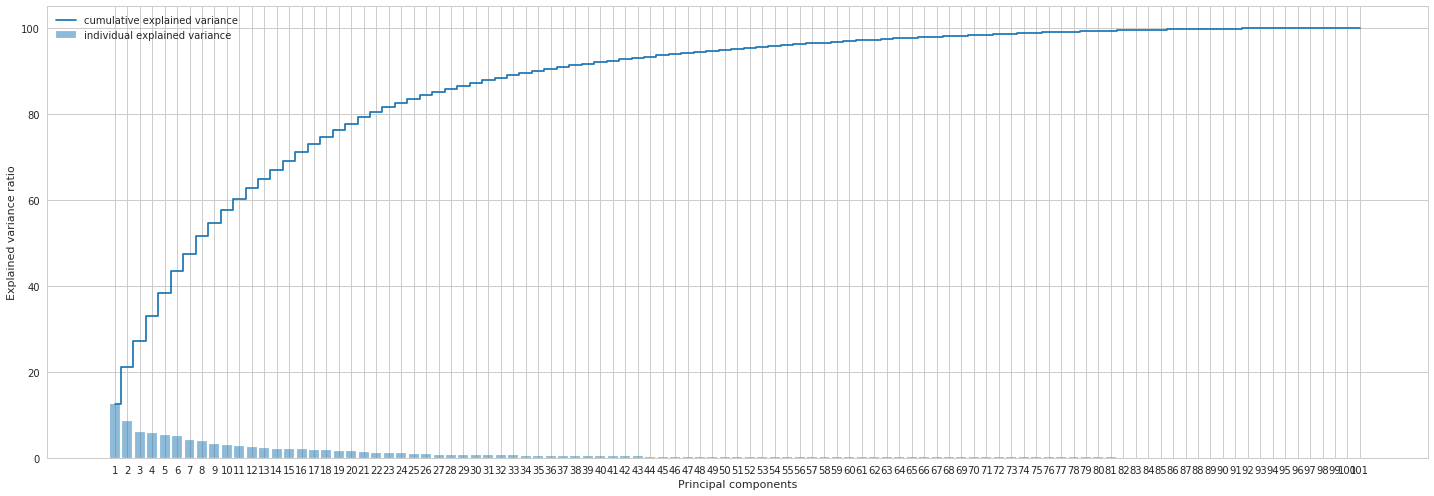

In [276]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(20, 7))
    plt.bar(range(101), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(101), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xticks(range(101))
    ax.set_xticklabels(np.arange(1, X_pca.shape[1] + 1))
    plt.legend(loc='best')
    plt.tight_layout()

In [277]:
pca = PCA(n_components=30)
pca.fit(x_train_transformed)
x_train_30_pca = pca.transform(x_train_transformed)
x_test_30_pca = pca.transform(x_test_transformed)

# A Haphazard Journey into Machine Learning and Natural Language Processing


## Learning Objectives

At the end of this tutorial, you will be able to:
- Describe machine learning's added value to our project
- Outline the basic steps of a machine learning project
- List and describe popular supervised learning approaches
- Describe potential ways to represent text numerically
- Compare model evaluation metrics

## Missing Majors Problem
A supervised classification problem

In [293]:
pd.DataFrame(y_df.sum().div(len(y_df))).T

,is_business,is_compsci,is_comms,is_publicadmin,is_business_admin_02,is_computer_science_07,is_comm_01,is_social_work
0,0.4758,0.2465,0.0432,0.0266,0.3078,0.2332,0.0344,0.0152


In [14]:
overall_df = features_df.merge(y_df, on='BGTJobId')
overall_df.head()

,BGTJobId,BestFitMSAName,CleanTitle,Employer,Exp,SectorName,SOCName,SkillClusterFamily,is_business,is_compsci,is_comms,is_publicadmin,is_business_admin_02,is_computer_science_07,is_comm_01,is_social_work
0,37904664186,"San Francisco-Oakland-Hayward, CA","General Manager, Hockey In",Sportvision,8.0,na,General and Operations Managers,Media and Writing Business Industry Knowledge ...,True,False,False,False,True,False,False,False
1,37902269463,"Provo-Orem, UT","Regional Director, Installation","Vivint, Inc",5.0,Administrative and Support and Waste Managemen...,Sales Managers,Human Resources Education and Training Busines...,True,False,False,False,True,False,False,False
2,37903093614,"Bridgeport-Stamford-Norwalk, CT",Assurance,McGladrey,-999.0,"Professional, Scientific, and Technical Services",Accountants and Auditors,Finance,True,False,False,False,False,False,False,False
3,37895498193,"Cleveland-Elyria, OH",Area Manager,XPO Logistics,4.0,"Professional, Scientific, and Technical Services",General and Operations Managers,Industry Knowledge Media and Writing Supply Ch...,True,False,False,False,True,False,False,False
4,37901172920,"Austin-Round Rock, TX",Desktop Administrator Reopened,Texas Comptroller Of Public Accounts,4.0,na,Computer User Support Specialists,"Information Technology Business Maintenance, R...",False,True,False,False,False,True,False,False


In [15]:
feat_to_show = ['CleanTitle', 'Employer', 'SectorName', 'Exp', 'SOCName', 'SkillClusterFamily']
overall_df[overall_df.is_compsci == True][feat_to_show].head()

,CleanTitle,Employer,SectorName,Exp,SOCName,SkillClusterFamily
4,Desktop Administrator Reopened,Texas Comptroller Of Public Accounts,na,4.0,Computer User Support Specialists,"Information Technology Business Maintenance, R..."
8,Principal Engineer,Navteq Corporation,na,8.0,"Engineers, All Other",Information Technology Engineering
9,Senior Lan Administrator - Code Sgnew,Segal Rogerscasey,"Professional, Scientific, and Technical Services",5.0,Network and Computer Systems Administrators,Information Technology Health Care Engineering...
13,Contact Center Software Development Consultant...,Voya Financial,Finance and Insurance,-999.0,"Software Developers, Applications",Information Technology Marketing and Public Re...
15,Business Systems Analyst Mckesson In,McKesson Corporation,Wholesale Trade,8.0,Computer Systems Analysts,Health Care Business Information Technology Hu...


# Brief Overview of an ML Project


![Machine Learning Workflow](https://raw.githubusercontent.com/chitralputhran/Logistic-Regression-for-Predicting-Survived-Passengers/master/Diagram.jpg)

In [48]:
# Taken from _Hands-on Machine Learning with Sci-kit learn_

## Defining the problem

- Defining end goals
- Checking assumptions
- Selecting performance measures

## Exploratory Analysis

- Have a look at data structure
- Visualize data
- Look for correlations

## Preparing the data for ML

- Data cleaning
- Handling text and categorical variables
- Feature scaling (standardize feature units)

## Training and selecting a model
- Training and evaluating on the training set
- Evaluating using cross-validation
- Analyzing best models and their errors

## Fine-tuning the model
- Grid/randomized search
- Ensemble methods

Fitting a model takes three components:
- A model that makes predictions
- A loss function
- An optimization method

# Baseline Classification Methods

## Logistic Regression

A logistic regression predicts the probability of occurrence of a binary event

Let $y \in \{\text{marketing}, \text{not_marketing}\}$ and $p(y) = \pi$

$\log(\frac{\pi}{1-\pi}) = \beta_0 + \beta_1 x_1 \longrightarrow \pi = \frac{e^{\beta_0 + \beta_1 x_1}}{1+e^{\beta_0 + \beta_1 x_1}} $

Decision boundary: 

$\hat{y}= 
\begin{cases}
    \text{marketing},& \text{if } P(y= 1 | x) > 0.5\\
    \text{not marketing},              & \text{otherwise}
\end{cases}
$

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1534281070/linear_vs_logistic_regression_edxw03.png)

### Learning in Logistic Regression

#### Cross-Entropy Loss Function
Also known as negative likelihood loss

$L(\hat{y},y) = \text{How much $\hat{y}$ differs from $y$}$

Conditional maximum likelihood estimation: choose parameters that maximize the log probability of the 'true' labels in the training data given $x$.

Useful properties:
Ranges from 0 to infinity, is convex (there is just one minimum and no local minima)

![Visualization of cross entropy lloss](https://miro.medium.com/max/1366/1*JLdsBjbAz2zwgQ9m977Bsw.png)

![Viz pt 2](https://miro.medium.com/max/868/1*72oORljVj0UjFFHLy1rJyA.png)

![Viz pt 3](https://miro.medium.com/max/882/1*i9EPio8R8j1Dd5kdaLy6pQ.png)

#### Gradient Descent

How do we minimize the loss function we defined earlier? ('Learning')

*Gradient descent* is an optimization algorithm to find the minimum of a function.

It starts at a random point on the function and moves in the opposite direction of the gradient of the function to find the local/global minima.

<img src="https://i.imgur.com/gJ7BzMG.png" alt="Drawing" style="width: 350px;"/>
<img src="https://i.imgur.com/nPwP9ca.png" alt="Drawing" style="width: 350px;"/>

## Predicting Computer Science

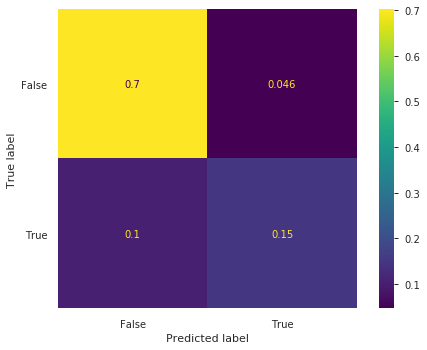

In [297]:
log_reg = LogisticRegression(C = 150, max_iter=7600, random_state=seed+1000)
log_reg.fit(x_train_30_pca, y_train['is_compsci'])

plot_confusion_matrix(log_reg, x_test_30_pca, y_test['is_compsci'], normalize='all',  values_format='.2g')

# Predicting Communications

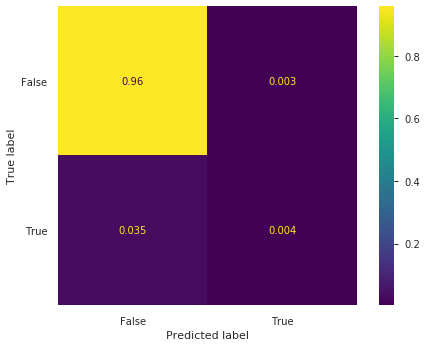

In [300]:
log_reg = LogisticRegression(C = 150, max_iter=7600, random_state=seed+1000)
log_reg.fit(x_train_30_pca, y_train['is_comms'])

plot_confusion_matrix(log_reg, x_test_30_pca, y_test['is_comms'], normalize='all',  values_format='.2g')

# Logistic Regression

Strengths
- Relatively less computationally intensive
- Easy to interpret
- Provides probability score

Weaknesses
- Does not handle large number of categorical variables well
- Prone to overfitting
- Does not perform well when large number of independent variables correlated

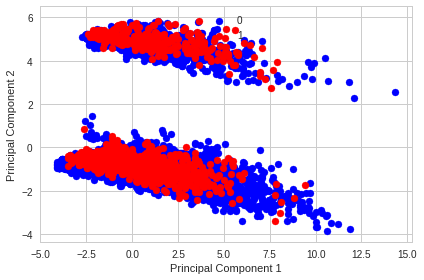

In [301]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip((0, 1),
                        ('blue', 'red')):
        plt.scatter(x_train_30_pca[y_train['is_compsci']==lab, 0],
                    x_train_30_pca[y_train['is_compsci']==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='upper center')
    plt.tight_layout()
    plt.show()

# Logistic Regression



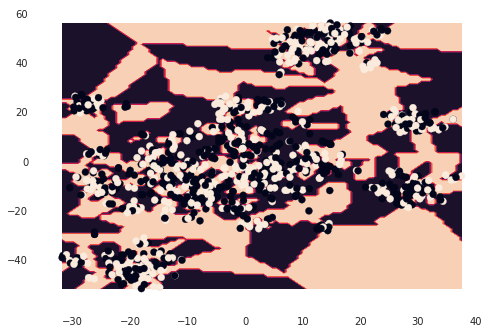

In [158]:
from sklearn.manifold.t_sne import TSNE
from sklearn.neighbors.classification import KNeighborsClassifier

x_test_embedded = TSNE(n_components=2).fit_transform(x_test_transformed)
y_test_predicted = log_reg.predict(x_test_transformed)

resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(x_test_embedded[:,0]), np.max(x_test_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(x_test_embedded[:,1]), np.max(x_test_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

background_model = KNeighborsClassifier(n_neighbors=1).fit(x_test_embedded, y_test_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

plt.contourf(xx, yy, voronoiBackground)
plt.scatter(x_test_embedded[:,0], x_test_embedded[:,1], c=y_test['is_business'])
plt.show()

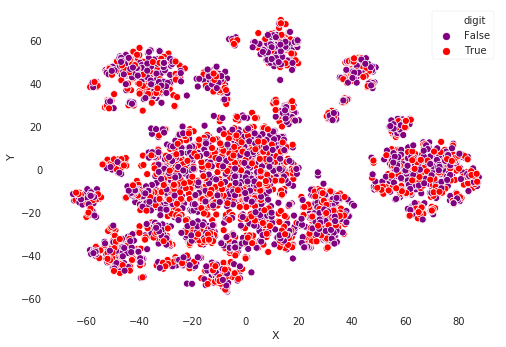

In [165]:
sns.scatterplot(x="X", y="Y",
              hue="digit",
              palette=['purple','red'],
              legend='full',
              data=tsne_df);

## Support Vector Machines

Tries to find a hyperplane that separates the different classes.

- More robust to individual observations
- Focuses on correctly solving the most difficult to identify cases

_Geometrically_ motivated as opposed to statistically.

![Wikipedia SVM](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/1280px-SVM_margin.png)

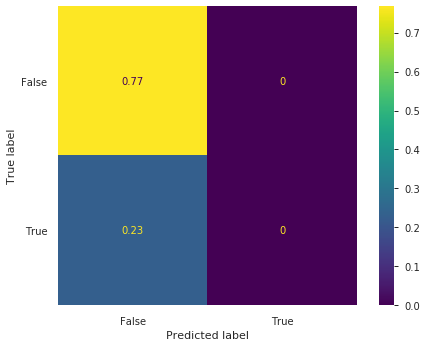

In [231]:
support_vec_machine = svm.SVC(C=0.1, kernel='rbf')
support_vec_machine.fit(x_train_35_pca, y_train['is_compsci'])

plot_confusion_matrix(support_vec_machine, x_test_35_pca, y_test['is_compsci'], normalize='all',  values_format='.2g')

# K-Nearest Neighbors

Defining a data point by its friends

Algorithm:
- Define a positive integer $k$
- Find the $k$ data points closest to the data point to be labelled
- Identify the most common classification for those data points


![KNN Pt 1](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png)

Credit to https://blog.usejournal.com/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7

Advantages:
- No assumptions about data — useful, for example, for nonlinear data
- Simple algorithm — to explain and understand/interpret

Disadvantages:
- Computationally expensive — because the algorithm stores all of the training data
- Stores all (or almost all) of the training data (High memory requirement)
- Prediction stage might be slow (with big N)
- Sensitive to irrelevant features and the scale of the data

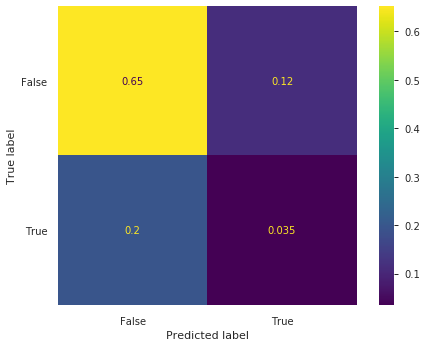

In [245]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_35_pca, y_train['is_compsci'])

plot_confusion_matrix(knn, x_test_35_pca, y_test['is_compsci'], normalize='all',  values_format='.2g')

# Decision Trees

Basic strategy: Split the data up into smaller groups that are more similar to one another (with respect to their label)

One "group similarity" is Gini impurity, which measures of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. 

$G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2$ where $p_{i,k}$ is the ratio of class $k$ instances in the ith node

Will likely outperform linear models when there is high non-linearity/complex relationships between variables


![](https://i.pinimg.com/originals/97/25/ad/9725ade3fadd79b6dc7a1232ce38113f.jpg)

In [ ]:
tree_clf_3 = DecisionTreeClassifier(max_depth=3)
tree_clf_3.fit(x_train_transformed, y_train['is_compsci'])

export_graphviz(tree_clf_3, out_file='tree3.dot', 
                     class_names=['not compsci', 'compsci'],  
                     filled=True, rounded=True,  
                     special_characters=True)

tree_clf_10 = DecisionTreeClassifier(max_depth=10)
tree_clf_10.fit(x_train_transformed, y_train['is_compsci'])

export_graphviz(tree_clf_10, out_file='tree10.dot', 
                     class_names=['not compsci', 'compsci'],  
                     filled=True, rounded=True,  
                     special_characters=True)  

tree_clf_5 = DecisionTreeClassifier(max_depth=5)
tree_clf_5.fit(x_train_transformed, y_train['is_compsci'])

export_graphviz(tree_clf_5, out_file='tree5.dot', 
                     class_names=['not compsci', 'compsci'],  
                     filled=True, rounded=True,  
                     special_characters=True)  

tree_clf_20 = DecisionTreeClassifier(max_depth=20)
tree_clf_.fit(x_train_transformed, y_train['is_compsci'])

export_graphviz(tree_clf_20, out_file='tree20.dot', 
                     class_names=['not compsci', 'compsci'],  
                     filled=True, rounded=True,  
                     special_characters=True)

# Depth = 3

![](tree3.png)

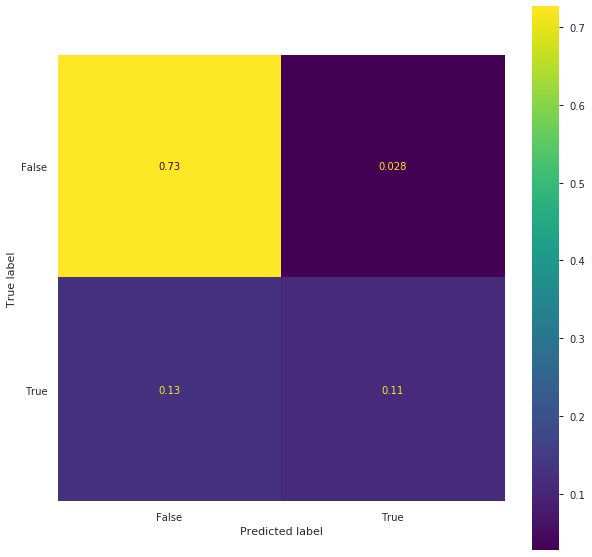

In [346]:
plot_confusion_matrix(tree_clf_3, x_train_transformed, y_train['is_compsci'], normalize='all', values_format='.2g')

# Depth = 5

![](tree5.png)

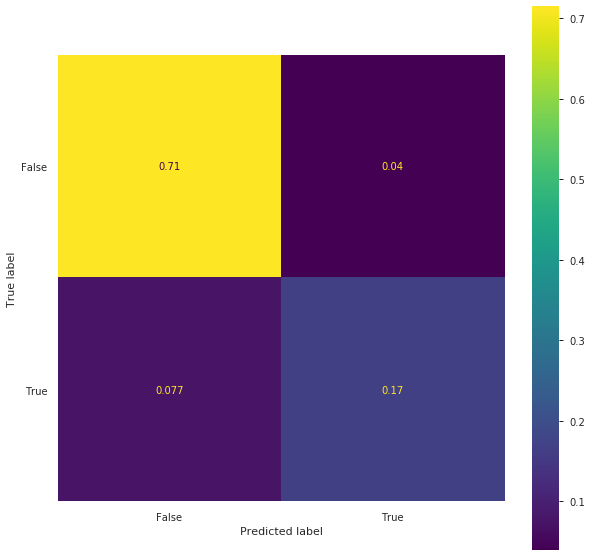

In [347]:
plot_confusion_matrix(tree_clf_5, x_train_transformed, y_train['is_compsci'], normalize='all', values_format='.2g')

# Depth = 10

![](tree10.png)

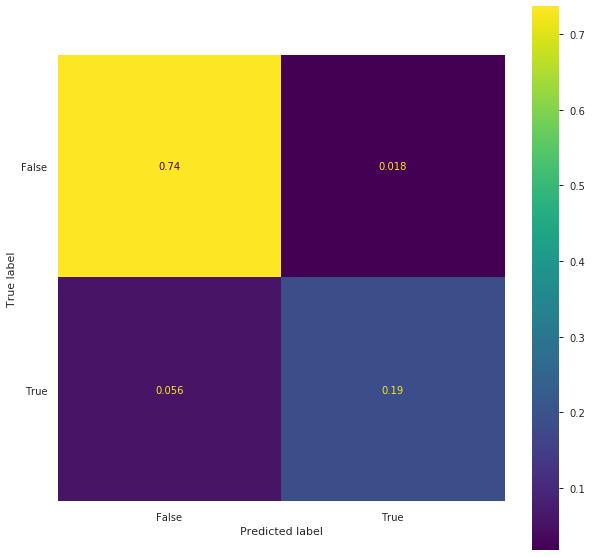

In [348]:
plot_confusion_matrix(tree_clf_10, x_train_transformed, y_train['is_compsci'], normalize='all', values_format='.2g')

# Depth = 20

![](tree20.png)


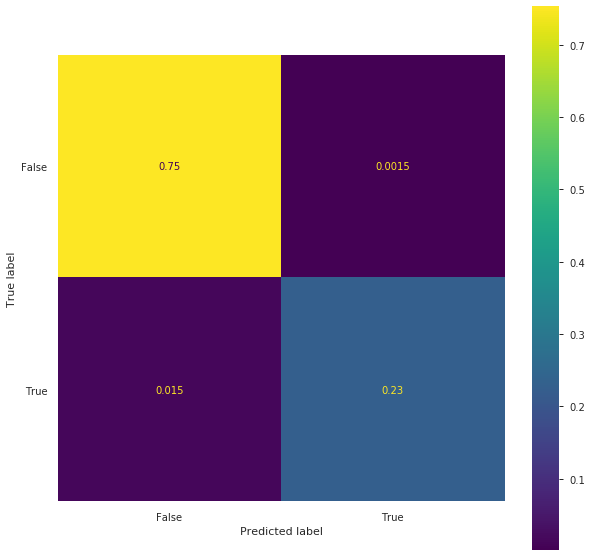

In [352]:
plot_confusion_matrix(tree_clf_20, x_train_transformed, y_train['is_compsci'], normalize='all', values_format='.2g')

Quick break

# Evaluation Metrics
_How do we know our classifier is good enough?_

**Sensitivity** = **Recall** = True Positive / (True Positive + False Negative)

How many of the jobs labelled major do we pick up?

**Specificity** = True Negative / (True Positive + True Negative)

How many of the negative labels are true? or How good is the algorithm at avoiding false alarms?


|| Positive Prediction | Negative Prediction |
|---|---|---|
| Positive Class | True Positive (TP)  | False Negative (FN) |
| Negative Class | False Positive (FP) | True Negative (TN) |


**Precision** = True Positive / (True Positive + False Positive)

How many of what we identified as a major was actually that major?

$\text{G-Mean (geometric mean)} = \sqrt(\text{Sensitivity} * \text{Specificity})$ 

$\text{F1 score} = \frac{2 * \text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}$

Kappa = (observed accuracy - expected accuracy)/(1 - expected accuracy)

Example
Observed accuracy = 0.60 ; expected = 0.50

$K = (0.60 - 0.50)/(1 - 0.50) = 0.20$

# Representing text as numbers

In [390]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=1)

vectorizer.fit([
    "The cat sat on the mat.",
])
vectorizer.vocabulary_

{'the': 4, 'cat': 0, 'sat': 3, 'on': 2, 'mat': 1}

In [377]:
x

,BestFitMSAName,CleanTitle,Employer,Exp,SectorName,SOCName,SkillClusterFamily
0,"San Francisco-Oakland-Hayward, CA","General Manager, Hockey In",Sportvision,8.0,na,General and Operations Managers,Media and Writing Business Industry Knowledge ...
1,"Provo-Orem, UT","Regional Director, Installation","Vivint, Inc",5.0,Administrative and Support and Waste Managemen...,Sales Managers,Human Resources Education and Training Busines...
2,"Bridgeport-Stamford-Norwalk, CT",Assurance,McGladrey,-999.0,"Professional, Scientific, and Technical Services",Accountants and Auditors,Finance
3,"Cleveland-Elyria, OH",Area Manager,XPO Logistics,4.0,"Professional, Scientific, and Technical Services",General and Operations Managers,Industry Knowledge Media and Writing Supply Ch...
4,"Austin-Round Rock, TX",Desktop Administrator Reopened,Texas Comptroller Of Public Accounts,4.0,na,Computer User Support Specialists,"Information Technology Business Maintenance, R..."
...,...,...,...,...,...,...,...
9995,"Trenton, NJ",Customer Service Manager Horticulture/Landscaping,Shemin Nurseries,3.0,Administrative and Support and Waste Managemen...,First-Line Supervisors of Office and Administr...,Finance Customer and Client Support Supply Cha...
9996,"San Antonio-New Braunfels, TX",Cybersecurity Specialist,Synchrony Financial,10.0,Finance and Insurance,Human Resources Specialists,Design Information Technology Finance Engineering
9997,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Insurance Sales,American National Property & Casualty Company,-999.0,Finance and Insurance,Insurance Sales Agents,Sales Marketing and Public Relations Business
9998,"Chicago-Naperville-Elgin, IL-IN-WI",Lead Generator,na,1.0,na,"Sales Representatives, Wholesale and Manufactu...",Information Technology Sales


In [388]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=1)

X_train_small = vectorizer.fit_transform(x.Combined)
vectorizer.get_feature_names()[len(vectorizer.get_feature_names()) // 2:(len(vectorizer.get_feature_names())) // 2 + 10]

['joint',
 'joseph',
 'journal',
 'journalist',
 'journeyman',
 'jr000578',
 'jr000685',
 'jrdc',
 'js',
 'json']

# PCA

Not well suited for text-related tasks.

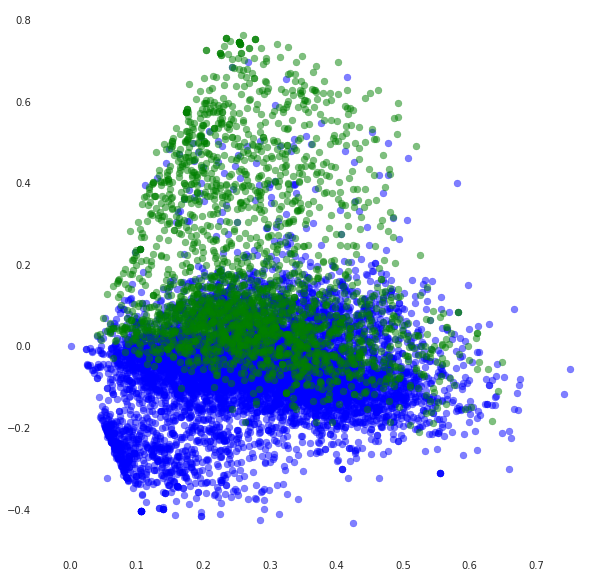

In [418]:
from sklearn.decomposition import TruncatedSVD

%time X_train_small_pca = TruncatedSVD(n_components=2).fit_transform(X_train_small)

from itertools import cycle

colors = ['b', 'g']
for i, c in zip(np.unique(y_train['is_compsci']), cycle(colors)):
    plt.scatter(X_train_small_pca[y['is_compsci'] == i, 0],
               X_train_small_pca[y['is_compsci'] == i, 1],
               c=c, alpha=0.5)

# Topic Modelling with LDA

[LDA Explained](https://www.youtube.com/watch?v=DWJYZq_fQ2A)

# Ensemble Learning


Intuition: Aggregating the predictions of a group of predictors (such as classifiers or regressors) gets better predictions than with the best individual predictor.

Example, **Random forests**: 
Train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you obtain the predictions of all the individual trees, then report your final prediction as the class that gets the most "votes".

# Voting Classifiers

![](https://i.imgur.com/COa6xjv.png)

# Bagging

Short for _bootstrap aggregating_

Use the same training algorithm for every predictor and train them on different random subsets of the training set.

![](https://i.imgur.com/aOtgAcA.png))

# Boosting

Train predictors _sequentially_, each trying to learn from their precdecessor.

The most popular boosting methods are: **AdaBoost** and **Gradient Boosting**

## AdaBoost

Each new predictor prioritizes learning from the data points its predecessor failed to classify correctly. This results in new predicators focusing more and more on hard cases.


![adaboost](https://i.imgur.com/gUFmuwN.png)

# Gradient Boosting

Like AdaBoost, sequentially adds predictors to an ensemble, with each predictors improving from the previous. It differs in that instead of re-prioritizing training data points, it fries the new predictor on the _residual errors_ made by the previous predictor.

![](https://i.imgur.com/b3ThMod.png)

Model selection
http://ml-ensemble.com/info/tutorials/start.html#model-selection-guide